In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 33s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [12]:
training_data_df['토지면적over총연면적times공시지가'] = training_data_df['토지면적'] / training_data_df['총연면적'] * training_data_df['공시지가(만원)']

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [13]:
shap_summary_df = pd.read_csv(basedir + 'shap_top_37.csv', index_col=[0]).sort_values(['shap_summary_mean'], ascending=False)
print(shap_summary_df.shape)
shap_summary_df.head()

(37, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.602443,94.388346,96.111830,92.957121,91.612637,93.334475
토지면적over총연면적times공시지가,74.163810,74.558704,79.545529,72.882027,74.952550,75.220524
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413


In [14]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.602443,94.388346,96.111830,92.957121,91.612637,93.334475
토지면적over총연면적times공시지가,74.163810,74.558704,79.545529,72.882027,74.952550,75.220524
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413
ynorm,32.778974,33.334156,34.381181,31.948810,31.985028,32.885630
xy,23.169878,22.911403,23.088237,23.200194,22.130894,22.900121
x_2nd,20.970331,19.983670,19.086148,19.561174,18.775874,19.675439
층mean,14.252191,13.117314,10.635972,12.298080,14.361368,12.932985
주건축물수,11.275807,11.011066,11.722058,10.505324,12.096255,11.322102


In [15]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [16]:
top_22_df = shap_summary_df.iloc[:22,:]
print(top_22_df.shape)
top_22_df.head()

(22, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,91.602443,94.388346,96.111830,92.957121,91.612637,93.334475
토지면적over총연면적times공시지가,74.163810,74.558704,79.545529,72.882027,74.952550,75.220524
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413


In [17]:
top_22_df.tail(20)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
year_linear,65.404750,65.156917,67.992698,65.330043,64.883900,65.753661
건축년도,50.980140,51.739771,51.910116,53.337124,48.834999,51.360430
전용면적,38.252657,39.128785,39.248705,41.074392,39.777527,39.496413
ynorm,32.778974,33.334156,34.381181,31.948810,31.985028,32.885630
xy,23.169878,22.911403,23.088237,23.200194,22.130894,22.900121
x_2nd,20.970331,19.983670,19.086148,19.561174,18.775874,19.675439
층mean,14.252191,13.117314,10.635972,12.298080,14.361368,12.932985
주건축물수,11.275807,11.011066,11.722058,10.505324,12.096255,11.322102
총건축면적,10.487300,8.622428,8.299764,10.033140,8.801621,9.248851
호수대비연면적,9.882119,8.960873,8.050227,8.596309,9.848030,9.067512


In [18]:
training_data_df = training_data_df[top_22_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 27)


,trade_type,토지면적over총연면적times공시지가,year_linear,건축년도,전용면적,ynorm,xy,x_2nd,층mean,주건축물수,총건축면적,호수대비연면적,토지이동상황,xnorm,아파트지구,옥내자주식대수,호수대비부속건축물면적,총호수,층,y_2nd,호수대비주차수,용도지역명1,금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,758.319895,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,2,4.094180e+07,0.0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
1,0,758.319895,7.916667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,2,4.094180e+07,0.0,0,57000.0,733.118971,10.950807,6.597308,서울특별시 강남구 개포동 655-2
2,1,758.319895,7.000000,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,4,4.094180e+07,0.0,0,35000.0,450.160772,10.463103,6.109605,서울특별시 강남구 개포동 655-2
3,1,758.319895,7.166667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,9,4.094180e+07,0.0,0,32000.0,411.575563,10.373491,6.019993,서울특별시 강남구 개포동 655-2
4,1,758.319895,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,9.0,1.0,6.27131,98.537963,0,5579.095707,0,0.0,0.0,54.0,1,4.094180e+07,0.0,0,37000.0,475.884244,10.518673,6.165175,서울특별시 강남구 개포동 655-2


# Training

In [19]:
from sklearn.model_selection import KFold, GroupKFold

In [20]:
import lightgbm as lgb

In [21]:
from sklearn.metrics import r2_score

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

4

In [24]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 22)
y dist plot


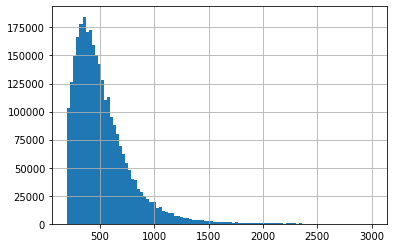

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3943
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 158.514
[100]	valid_0's huber: 123.485
[150]	valid_0's huber: 108.075
[200]	valid_0's huber: 99.654
[250]	valid_0's huber: 94.0336
[300]	valid_0's huber: 89.9176
[350]	valid_0's huber: 86.7766
[400]	valid_0's huber: 84.1642
[450]	valid_0's huber: 82.0897
[500]	valid_0's huber: 80.4861
[550]	valid_0's huber: 78.843
[600]	valid_0's huber: 77.6305
[650]	valid_0's huber: 76.6391
[700]	valid_0's huber: 75.7107
[750]	valid_0's huber: 74.8529
[800]	valid_0's huber: 74.0511
[850]	valid_0's huber: 73.245
[900]	valid_0's huber: 72.6077
[950]	valid_0's huber: 71.8995
[1000]	valid_0's huber: 71.4217
[1050]	valid_0's huber: 70.804
[1100]	valid_0's huber: 70.1371
[1150]	valid_0's huber: 69.5855
[1200]	valid_0's huber: 69.0511
[1250]	valid_0's huber: 68.6014
[1300]	valid_0's huber: 68.164
[1350]	valid_0's huber: 67.7713
[1400]	valid_0's huber: 67.4005
[1450]	valid

[12700]	valid_0's huber: 51.1348
[12750]	valid_0's huber: 51.1149
[12800]	valid_0's huber: 51.0991
[12850]	valid_0's huber: 51.081
[12900]	valid_0's huber: 51.0634
[12950]	valid_0's huber: 51.044
[13000]	valid_0's huber: 51.0276
[13050]	valid_0's huber: 51.0052
[13100]	valid_0's huber: 50.984
[13150]	valid_0's huber: 50.9659
[13200]	valid_0's huber: 50.9425
[13250]	valid_0's huber: 50.9243
[13300]	valid_0's huber: 50.9023
[13350]	valid_0's huber: 50.8866
[13400]	valid_0's huber: 50.869
[13450]	valid_0's huber: 50.8541
[13500]	valid_0's huber: 50.8357
[13550]	valid_0's huber: 50.8174
[13600]	valid_0's huber: 50.7969
[13650]	valid_0's huber: 50.7789
[13700]	valid_0's huber: 50.766
[13750]	valid_0's huber: 50.7487
[13800]	valid_0's huber: 50.7317
[13850]	valid_0's huber: 50.7161
[13900]	valid_0's huber: 50.6992
[13950]	valid_0's huber: 50.6831
[14000]	valid_0's huber: 50.666
[14050]	valid_0's huber: 50.6509
[14100]	valid_0's huber: 50.6381
[14150]	valid_0's huber: 50.6256
[14200]	valid_0'

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


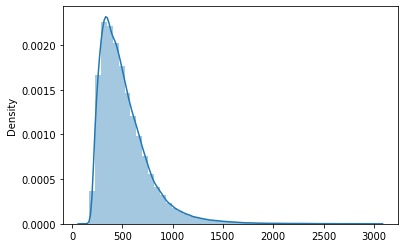

Fold 0 end
Fold 1 start
(2926581, 22)
y dist plot


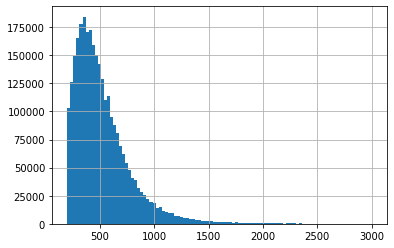

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 158.858
[100]	valid_0's huber: 123.643
[150]	valid_0's huber: 108.223
[200]	valid_0's huber: 99.7542
[250]	valid_0's huber: 94.0676
[300]	valid_0's huber: 89.9078
[350]	valid_0's huber: 86.5779
[400]	valid_0's huber: 84.105
[450]	valid_0's huber: 82.1393
[500]	valid_0's huber: 80.4111
[550]	valid_0's huber: 78.9706
[600]	valid_0's huber: 77.5936
[650]	valid_0's huber: 76.4661
[700]	valid_0's huber: 75.4131
[750]	valid_0's huber: 74.4756
[800]	valid_0's huber: 73.726
[850]	valid_0's huber: 72.919
[900]	valid_0's huber: 72.1498
[950]	valid_0's huber: 71.44
[1000]	valid_0's huber: 70.869
[1050]	valid_0's huber: 70.3187
[1100]	valid_0's huber: 69.7363
[1150]	valid_0's huber: 69.3043
[1200]	valid_0's huber: 68.9658
[1250]	valid_0's huber: 68.4737
[1300]	valid_0's huber: 68.0997
[1350]	valid_0's huber: 67.7489
[1400]	valid_0's huber: 67.3374
[1450]	valid_

[12700]	valid_0's huber: 50.979
[12750]	valid_0's huber: 50.9604
[12800]	valid_0's huber: 50.9426
[12850]	valid_0's huber: 50.929
[12900]	valid_0's huber: 50.915
[12950]	valid_0's huber: 50.9005
[13000]	valid_0's huber: 50.8834
[13050]	valid_0's huber: 50.8702
[13100]	valid_0's huber: 50.8525
[13150]	valid_0's huber: 50.8382
[13200]	valid_0's huber: 50.8203
[13250]	valid_0's huber: 50.8033
[13300]	valid_0's huber: 50.7881
[13350]	valid_0's huber: 50.7766
[13400]	valid_0's huber: 50.775
[13450]	valid_0's huber: 50.7729
[13500]	valid_0's huber: 50.7717
[13550]	valid_0's huber: 50.7702
[13600]	valid_0's huber: 50.7679
[13650]	valid_0's huber: 50.7672
[13700]	valid_0's huber: 50.7651
[13750]	valid_0's huber: 50.7638
[13800]	valid_0's huber: 50.7607
[13850]	valid_0's huber: 50.7591
[13900]	valid_0's huber: 50.757
[13950]	valid_0's huber: 50.7561
[14000]	valid_0's huber: 50.7556
[14050]	valid_0's huber: 50.7548
[14100]	valid_0's huber: 50.7515
[14150]	valid_0's huber: 50.7504
[14200]	valid_0

[25200]	valid_0's huber: 50.3274
[25250]	valid_0's huber: 50.3238
[25300]	valid_0's huber: 50.3211
[25350]	valid_0's huber: 50.3181
[25400]	valid_0's huber: 50.3154
[25450]	valid_0's huber: 50.3121
[25500]	valid_0's huber: 50.3083
[25550]	valid_0's huber: 50.3041
[25600]	valid_0's huber: 50.2982
[25650]	valid_0's huber: 50.294
[25700]	valid_0's huber: 50.2897
[25750]	valid_0's huber: 50.2847
[25800]	valid_0's huber: 50.2823
[25850]	valid_0's huber: 50.2815
[25900]	valid_0's huber: 50.2802
[25950]	valid_0's huber: 50.2788
[26000]	valid_0's huber: 50.2769
[26050]	valid_0's huber: 50.2757
[26100]	valid_0's huber: 50.275
[26150]	valid_0's huber: 50.2749
[26200]	valid_0's huber: 50.2746
[26250]	valid_0's huber: 50.274
[26300]	valid_0's huber: 50.2735
[26350]	valid_0's huber: 50.2732
[26400]	valid_0's huber: 50.2727
[26450]	valid_0's huber: 50.2717
[26500]	valid_0's huber: 50.27
[26550]	valid_0's huber: 50.2684
[26600]	valid_0's huber: 50.266
[26650]	valid_0's huber: 50.2639
[26700]	valid_0'

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


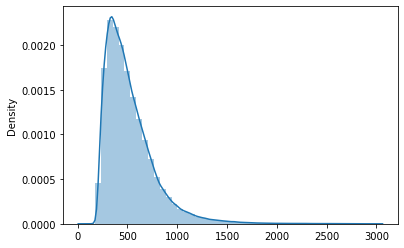

Fold 1 end
Fold 2 start
(2926581, 22)
y dist plot


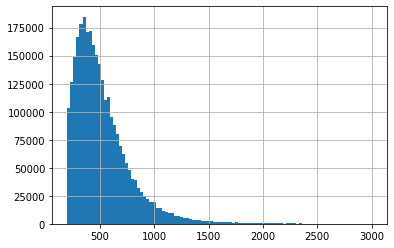

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 158.538
[100]	valid_0's huber: 123.457
[150]	valid_0's huber: 108.066
[200]	valid_0's huber: 99.5246
[250]	valid_0's huber: 93.8453
[300]	valid_0's huber: 89.8809
[350]	valid_0's huber: 86.6
[400]	valid_0's huber: 84.0025
[450]	valid_0's huber: 81.967
[500]	valid_0's huber: 80.2433
[550]	valid_0's huber: 78.7849
[600]	valid_0's huber: 77.4884
[650]	valid_0's huber: 76.3366
[700]	valid_0's huber: 75.4088
[750]	valid_0's huber: 74.5085
[800]	valid_0's huber: 73.6976
[850]	valid_0's huber: 72.91
[900]	valid_0's huber: 72.1836
[950]	valid_0's huber: 71.5224
[1000]	valid_0's huber: 70.8738
[1050]	valid_0's huber: 70.2831
[1100]	valid_0's huber: 69.7603
[1150]	valid_0's huber: 69.2658
[1200]	valid_0's huber: 68.7749
[1250]	valid_0's huber: 68.2944
[1300]	valid_0's huber: 67.8409
[1350]	valid_0's huber: 67.3865
[1400]	valid_0's huber: 66.994
[1450]	valid_0

[12700]	valid_0's huber: 51.546
[12750]	valid_0's huber: 51.5401
[12800]	valid_0's huber: 51.5338
[12850]	valid_0's huber: 51.5284
[12900]	valid_0's huber: 51.5229
[12950]	valid_0's huber: 51.5174
[13000]	valid_0's huber: 51.5118
[13050]	valid_0's huber: 51.5069
[13100]	valid_0's huber: 51.5007
[13150]	valid_0's huber: 51.4951
[13200]	valid_0's huber: 51.4884
[13250]	valid_0's huber: 51.4823
[13300]	valid_0's huber: 51.4779
[13350]	valid_0's huber: 51.4729
[13400]	valid_0's huber: 51.4685
[13450]	valid_0's huber: 51.4642
[13500]	valid_0's huber: 51.459
[13550]	valid_0's huber: 51.4555
[13600]	valid_0's huber: 51.4507
[13650]	valid_0's huber: 51.4457
[13700]	valid_0's huber: 51.44
[13750]	valid_0's huber: 51.4352
[13800]	valid_0's huber: 51.4302
[13850]	valid_0's huber: 51.424
[13900]	valid_0's huber: 51.4201
[13950]	valid_0's huber: 51.4159
[14000]	valid_0's huber: 51.4109
[14050]	valid_0's huber: 51.4056
[14100]	valid_0's huber: 51.399
[14150]	valid_0's huber: 51.3947
[14200]	valid_0'

[25200]	valid_0's huber: 50.7134
[25250]	valid_0's huber: 50.7113
[25300]	valid_0's huber: 50.7095
[25350]	valid_0's huber: 50.7072
[25400]	valid_0's huber: 50.7057
[25450]	valid_0's huber: 50.7041
[25500]	valid_0's huber: 50.7017
[25550]	valid_0's huber: 50.7001
[25600]	valid_0's huber: 50.6984
[25650]	valid_0's huber: 50.6966
[25700]	valid_0's huber: 50.6952
[25750]	valid_0's huber: 50.6932
[25800]	valid_0's huber: 50.6905
[25850]	valid_0's huber: 50.6885
[25900]	valid_0's huber: 50.6864
[25950]	valid_0's huber: 50.6845
[26000]	valid_0's huber: 50.6825
[26050]	valid_0's huber: 50.6809
[26100]	valid_0's huber: 50.6789
[26150]	valid_0's huber: 50.6777
[26200]	valid_0's huber: 50.6757
[26250]	valid_0's huber: 50.674
[26300]	valid_0's huber: 50.6722
[26350]	valid_0's huber: 50.6701
[26400]	valid_0's huber: 50.6681
[26450]	valid_0's huber: 50.6667
[26500]	valid_0's huber: 50.6648
[26550]	valid_0's huber: 50.6631
[26600]	valid_0's huber: 50.6606
[26650]	valid_0's huber: 50.6586
[26700]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


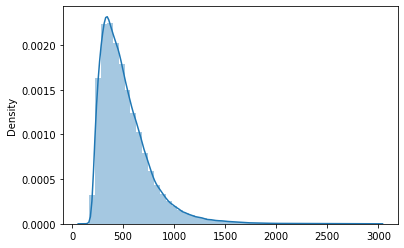

Fold 2 end
Fold 3 start
(2926581, 22)
y dist plot


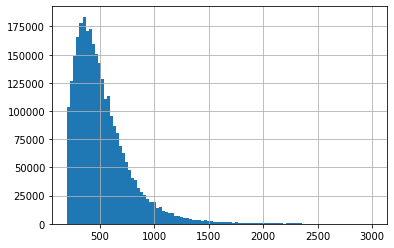

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3941
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 158.562
[100]	valid_0's huber: 123.36
[150]	valid_0's huber: 107.957
[200]	valid_0's huber: 99.5945
[250]	valid_0's huber: 94.0065
[300]	valid_0's huber: 89.8849
[350]	valid_0's huber: 86.8325
[400]	valid_0's huber: 84.2121
[450]	valid_0's huber: 81.9285
[500]	valid_0's huber: 80.2796
[550]	valid_0's huber: 78.788
[600]	valid_0's huber: 77.5034
[650]	valid_0's huber: 76.4034
[700]	valid_0's huber: 75.3923
[750]	valid_0's huber: 74.4591
[800]	valid_0's huber: 73.6117
[850]	valid_0's huber: 72.9315
[900]	valid_0's huber: 72.3593
[950]	valid_0's huber: 71.7135
[1000]	valid_0's huber: 71.0932
[1050]	valid_0's huber: 70.4759
[1100]	valid_0's huber: 69.9167
[1150]	valid_0's huber: 69.4889
[1200]	valid_0's huber: 69.0399
[1250]	valid_0's huber: 68.5297
[1300]	valid_0's huber: 68.0715
[1350]	valid_0's huber: 67.6977
[1400]	valid_0's huber: 67.2881
[1450]	va

[12700]	valid_0's huber: 51.1213
[12750]	valid_0's huber: 51.1156
[12800]	valid_0's huber: 51.1133
[12850]	valid_0's huber: 51.0959
[12900]	valid_0's huber: 51.089
[12950]	valid_0's huber: 51.0852
[13000]	valid_0's huber: 51.0735
[13050]	valid_0's huber: 51.0664
[13100]	valid_0's huber: 51.0587
[13150]	valid_0's huber: 51.0566
[13200]	valid_0's huber: 51.0526
[13250]	valid_0's huber: 51.0496
[13300]	valid_0's huber: 51.0451
[13350]	valid_0's huber: 51.0413
[13400]	valid_0's huber: 51.0361
[13450]	valid_0's huber: 51.0312
[13500]	valid_0's huber: 51.0271
[13550]	valid_0's huber: 51.0235
[13600]	valid_0's huber: 51.0178
[13650]	valid_0's huber: 51.0145
[13700]	valid_0's huber: 51.0119
[13750]	valid_0's huber: 51.0086
[13800]	valid_0's huber: 51.0076
[13850]	valid_0's huber: 51.0049
[13900]	valid_0's huber: 51.0016
[13950]	valid_0's huber: 50.9977
[14000]	valid_0's huber: 50.9951
[14050]	valid_0's huber: 50.9932
[14100]	valid_0's huber: 50.9902
[14150]	valid_0's huber: 50.9863
[14200]	val

[25200]	valid_0's huber: 50.129
[25250]	valid_0's huber: 50.1262
[25300]	valid_0's huber: 50.1238
[25350]	valid_0's huber: 50.1215
[25400]	valid_0's huber: 50.1188
[25450]	valid_0's huber: 50.1149
[25500]	valid_0's huber: 50.1114
[25550]	valid_0's huber: 50.1085
[25600]	valid_0's huber: 50.1054
[25650]	valid_0's huber: 50.1014
[25700]	valid_0's huber: 50.0983
[25750]	valid_0's huber: 50.0954
[25800]	valid_0's huber: 50.0914
[25850]	valid_0's huber: 50.089
[25900]	valid_0's huber: 50.0867
[25950]	valid_0's huber: 50.0828
[26000]	valid_0's huber: 50.0809
[26050]	valid_0's huber: 50.0782
[26100]	valid_0's huber: 50.075
[26150]	valid_0's huber: 50.0716
[26200]	valid_0's huber: 50.0668
[26250]	valid_0's huber: 50.0627
[26300]	valid_0's huber: 50.0602
[26350]	valid_0's huber: 50.0578
[26400]	valid_0's huber: 50.0564
[26450]	valid_0's huber: 50.0544
[26500]	valid_0's huber: 50.0514
[26550]	valid_0's huber: 50.0478
[26600]	valid_0's huber: 50.0453
[26650]	valid_0's huber: 50.0445
[26700]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


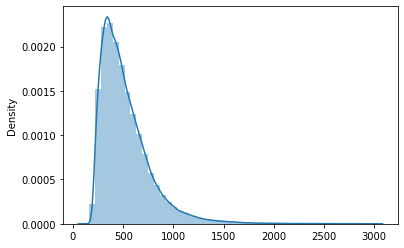

Fold 3 end
Fold 4 start
(2926581, 22)
y dist plot


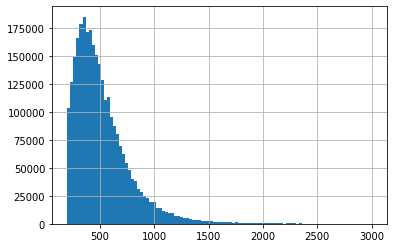

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 22


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 100 rounds
[50]	valid_0's huber: 158.446
[100]	valid_0's huber: 123.294
[150]	valid_0's huber: 108.03
[200]	valid_0's huber: 99.5801
[250]	valid_0's huber: 93.9481
[300]	valid_0's huber: 89.8376
[350]	valid_0's huber: 86.6852
[400]	valid_0's huber: 83.9705
[450]	valid_0's huber: 81.8432
[500]	valid_0's huber: 80.1354
[550]	valid_0's huber: 78.6603
[600]	valid_0's huber: 77.4503
[650]	valid_0's huber: 76.3685
[700]	valid_0's huber: 75.3553
[750]	valid_0's huber: 74.4355
[800]	valid_0's huber: 73.6449
[850]	valid_0's huber: 72.9749
[900]	valid_0's huber: 72.3646
[950]	valid_0's huber: 71.7458
[1000]	valid_0's huber: 71.1291
[1050]	valid_0's huber: 70.6122
[1100]	valid_0's huber: 70.1043
[1150]	valid_0's huber: 69.5967
[1200]	valid_0's huber: 69.1586
[1250]	valid_0's huber: 68.6986
[1300]	valid_0's huber: 68.1794
[1350]	valid_0's huber: 67.7702
[1400]	valid_0's huber: 67.4139
[1450]	v

[12650]	valid_0's huber: 51.4571
[12700]	valid_0's huber: 51.4509
[12750]	valid_0's huber: 51.4449
[12800]	valid_0's huber: 51.4408
[12850]	valid_0's huber: 51.4358
[12900]	valid_0's huber: 51.4309
[12950]	valid_0's huber: 51.4266
[13000]	valid_0's huber: 51.4197
[13050]	valid_0's huber: 51.4142
[13100]	valid_0's huber: 51.409
[13150]	valid_0's huber: 51.4016
[13200]	valid_0's huber: 51.3957
[13250]	valid_0's huber: 51.3878
[13300]	valid_0's huber: 51.3792
[13350]	valid_0's huber: 51.3701
[13400]	valid_0's huber: 51.3621
[13450]	valid_0's huber: 51.3536
[13500]	valid_0's huber: 51.3448
[13550]	valid_0's huber: 51.3351
[13600]	valid_0's huber: 51.3266
[13650]	valid_0's huber: 51.3174
[13700]	valid_0's huber: 51.3109
[13750]	valid_0's huber: 51.3033
[13800]	valid_0's huber: 51.2955
[13850]	valid_0's huber: 51.2861
[13900]	valid_0's huber: 51.2783
[13950]	valid_0's huber: 51.2693
[14000]	valid_0's huber: 51.2599
[14050]	valid_0's huber: 51.2521
[14100]	valid_0's huber: 51.2439
[14150]	val

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


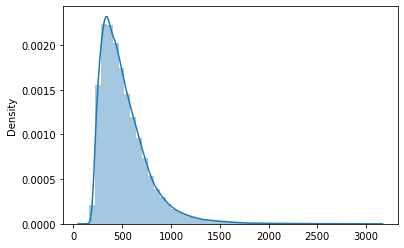

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [25]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'alpha': 1.35,
        'learning_rate': 3,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 50000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=100, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_top_22_lr_3_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[sample_x.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
    
    print('Fold {} end'.format(count))
    count += 1

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

64.65303086204757

In [28]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [29]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [30]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [31]:
shap_summary_df.index = x_train.columns

In [32]:
shap_summary_df.to_csv(basedir + 'shap_top_22.csv')

In [33]:
shap_summary_df = shap_summary_df.sort_values(['shap_summary_mean'], ascending=False)

In [34]:
shap_summary_df.shape

(22, 6)

In [35]:
shap_summary_df

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.820917,97.153154,93.304250,93.761785,94.252643,94.458550
토지면적over총연면적times공시지가,71.489308,73.258290,76.002862,72.472447,76.035547,73.851691
year_linear,65.421895,65.083373,66.493716,65.274088,64.053698,65.265354
건축년도,53.396990,53.400304,51.292150,51.734241,50.729348,52.110607
전용면적,40.123015,37.876511,40.318999,38.256690,37.952788,38.905601
ynorm,36.097039,34.625306,34.534436,34.035008,33.736799,34.605718
xy,24.518383,26.779659,23.781839,24.773154,25.667270,25.104061
x_2nd,22.278400,19.265440,21.116497,19.203568,19.449056,20.262592
주건축물수,13.010409,13.076288,13.531683,12.420874,13.522682,13.112387
층mean,11.658743,11.859443,13.322617,13.463254,12.567608,12.574333


In [36]:
#